# ABC-SMC

PINTS can be used to perform inference for stochastic forward models. Here, we perform inference on the [stochastic degradation model](../toy/model-stochastic-degradation.ipynb) using Approximate Bayesian Computation (ABC). This model has only a single unknown parameter -- the rate at which chemicals degrade. We use the "ABC SMC" method to estimate this unknown and provide a measure of uncertainty in it.

First, we load the stochastic degradation model and perform 10 simulations from it. The variation inbetween runs is due to the inherent stochasticity of this type of model.

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

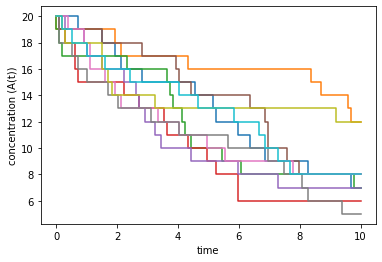

In [2]:
np.random.seed(5)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

for i in range(10):
    values = model.simulate(real_parameters, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using ABC SMC

The ABC SMC method can be used to perform parameter inference for stochastic models, where the likelihood is intractable. In ABC methods, typically, a distance metric comparing the observed data and the simulated is used. Here, we use the root mean square error (RMSE), and we accept a parameter value if the $RMSE<3$ for the first intermediate distribution, $RMSE<1.5$ for the second one and $RMSE<1$ for the last. The size of the intermediate distributions will be 200.

In [3]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([3,1.5,1]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=3.0
Starting t=1, with threshold=1.5
Starting t=2, with threshold=1.0
Iter. Eval. Acceptance rate Time m:s
1     2025   0.00049382716    0:02.1
2     2054   0.000973709834   0:02.1
3     2066   0.00145208132    0:02.1
20    2646   0.00755857899    0:02.5
40    3300   0.0121212121     0:02.9
60    4348   0.013799448      0:03.6
80    5075   0.0157635468     0:04.0
100   5687   0.0175839634     0:04.4
120   6377   0.0188176258     0:04.9
140   6955   0.0201294033     0:05.2
160   7592   0.0210748156     0:05.6
180   8053   0.0223519185     0:05.9
200   8735   0.0228963938     0:06.3
220   9380   0.0234541578     0:06.7
240   10165  0.0236104279     0:07.2
260   10881  0.0238948626     0:07.7
280   11510  0.0243266725     0:08.1
300   12359  0.0242738086     0:08.6
320   13093  0.0244405407     0:09.0
340   13951  0.0243710128     0:09.5
360   14770  0.0243737305     0:10.0
380   15481  0.0245462179     0:10

We now plot the ABC posterior samples versus the actual value that was used to generate the data. This shows that, in this case, the parameter could be identified given the data.

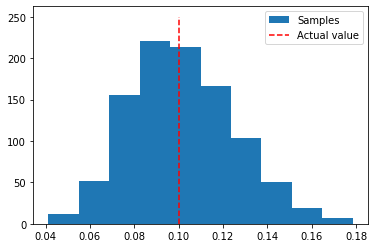

In [4]:
plt.hist([x[0] for x in samples], label='Samples')

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')
plt.legend()
plt.show()

# Using the ask and tell interface

We can use the ask-and-tell interface to visualise the algorithm's behaviour. In this example we run ABC-SMC with 3 successive generations (iterations 0-200, 200-400 and 400-1000) and plot each generation separately.

In [28]:
abcsmc = pints.ABCSMC(log_prior, nr_samples=200, error_schedule=np.array([3,1.5,1]))

evaluator = pints.SequentialEvaluator(error_measure)

print("Starting sampler")
f = []
s = []
l = []
cnt = 0
np.random.seed(1)
running = True
while cnt < 1000:
    accepted_vals = None
    while accepted_vals is None:
        xs = abcsmc.ask(1)
        fxs = evaluator.evaluate(xs)
        accepted_vals = abcsmc.tell(fxs)
    if cnt < 200:
        for val in accepted_vals:
            f.append(val)
    elif cnt < 400:
        for val in accepted_vals:
            s.append(val)
    else:
        for val in accepted_vals:
            l.append(val)
    cnt += len(accepted_vals)

# log to screen
abc.set_log_to_screen(True)
print("Sampler finished")

Starting sampler
Starting t=0, with threshold=3.0
Starting t=1, with threshold=1.5
Starting t=2, with threshold=1.0
Sampler finished


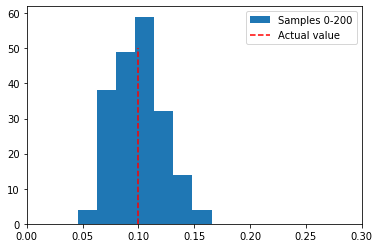

In [29]:
plt.hist([x[0] for x in f], bins=7, label='Samples 0-200')
plt.xlim(0, 0.3)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=50, label='Actual value', color='red')
plt.legend()
plt.show()

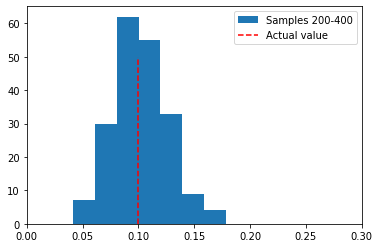

In [30]:
plt.hist([x[0] for x in s], bins=7, label='Samples 200-400')
plt.xlim(0, 0.3)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=50, label='Actual value', color='red')
plt.legend()
plt.show()

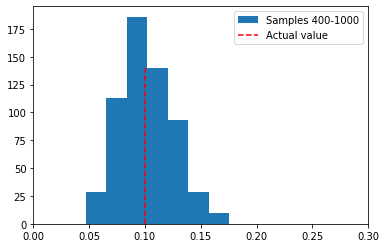

In [31]:
plt.hist([x[0] for x in l], bins=7, label='Samples 400-1000')
plt.xlim(0, 0.3)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=140, label='Actual value', color='red')
plt.legend()
plt.show()